In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pandas as pd
import warnings
from matplotlib import pyplot as plt
from matplotlib.cm import rainbow
import collections
from tqdm import tqdm_notebook as tqdm
import scipy.stats as sps
import pickle

import tensorflow as tf
import tensorflow_probability as tfp
from IPython.display import clear_output

%matplotlib inline

np.seterr(all='raise')
tfd = tfp.distributions


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
from datasets import *

In [3]:
data_set_small = load_data_set('./datasets/100.10')
data_set_big = load_data_set('./datasets/100.100')

In [4]:
%%writefile basic_solutions.py

import numpy as np
from scipy.optimize import minimize
import scipy.stats as sps
from matplotlib import pyplot as plt

def cut01(ans):
    if np.isscalar(ans):
        return np.clip(ans, 1e-4, 1 - 1e-4)
    ans[ans <= 1e-4] = 1e-4
    ans[ans >= 1 - 1e-4] = 1 - 1e-4
    return ans

def bayesian_solve(alpha0, beta0, train, L):
    ans = (train + alpha0 - 1) / (L + alpha0 + beta0 - 2)
    return cut01(ans)

def calc_loglike(p_pred, val, L):
    if (p_pred >= 1).sum() + (p_pred <= 0).sum() > 0:
        print (p_pred)
        print ('aaaaaa!!!!1111')
    return (val * np.log(p_pred)).sum() + ((L - val) * np.log(1 - p_pred)).sum()

def calc_bayesian_solve_loglike(alpha0, beta0, train, val, L, use_prior=False):
    p_pred = bayesian_solve(alpha0, beta0, train, L)
    ans = calc_loglike(p_pred, val, L)
    if use_prior:
        m = alpha0 / (alpha0 + beta0)
        s = alpha0 + beta0
        ans += sps.beta.logpdf(m, 1, 10)
        ans += sps.norm(4, 1).logpdf(np.log(s))
    return ans

def stupid_solution(train, val, L):
    return cut01((train + val) / 2 / L)

def calc_llp(p_pred, train, test, L):
    p_pred = cut01(p_pred)
    p_const = cut01(train.sum() / L / train.shape[0])
    return (calc_loglike(p_pred, test, 1e6) - calc_loglike(p_const, test, 1e6)) / 1e6 / test.shape[0]

def evaluate(solution_fun, train, val, test, L):
    p_pred = solution_fun(train, val, L)
    if np.any(p_pred == 0):
        raise Exception("Zero predicted probability")
        

    #print ("p_pred", p_pred[:5])
    #print (test[:5] / 1e6)
    #plt.hist(test / 1e6, bins=20, density=True)
    #plt.show()
    return calc_llp(p_pred, train + val, test, 2 * L)

def max_loglike_solution(train, val, L):
    loglike = lambda x: calc_bayesian_solve_loglike(x[0], x[1], train, val, L)
    try:
        res = minimize(fun=lambda x: -loglike(1 + np.exp(x)), x0=(1, 1))
    except FloatingPointError as e:
        return mean_value_solution(train, val, L)
    if not res.success:
        return mean_value_solution(train, val, L)
    else:
        return bayesian_solve(1 + np.exp(res.x[0]), 1 + np.exp(res.x[1]), train + val, L * 2)
    
def mean_value_solution(train, val, L):
    m = ((train + val) / 2. / L).mean()
    m = cut01(m)
    sum_ab = 1 / m * 20
    return bayesian_solve(m * sum_ab, (1 - m) * sum_ab, train + val, 2 * L)

def calibration_curve_solution(train, val, L):
    try:
        line = sps.linregress((val) / L, (train) / L, )
    except FloatingPointError as e:
        return max_loglike_solution(train, val, L)
    if line.slope == 0:
        return max_loglike_solution(train, val, L)
    tg = 1 / line.slope
    sum_ab = tg * L - L + 2
    if sum_ab == 0:
        return max_loglike_solution(train, val, L)
    m = (L * line.intercept / line.slope + 1) / sum_ab
    if tg != tg or m * sum_ab < 1 or sum_ab > 1e5 or m > 1:
        return max_loglike_solution(train, val, L)
    
    space = np.linspace(0, .2, 100)
    return bayesian_solve(m * sum_ab, sum_ab * (1 - m), train + val, 2 * L)

def mean_std_prior(p):
    m = p.mean()
    sq_std = p.std() ** 2
    if sq_std == 0:
        return None, None
    sum_ab = m * (1 - m) / sq_std
    if m * sum_ab < 1 or sum_ab != sum_ab:
        return None, None
    return m * sum_ab, (1 - m) * sum_ab

def mean_std_value_solution(train, val, L, iters=2):
    alpha, beta = mean_std_prior((train + val) / 2 / L)
    
    for i in range(iters):
        if alpha is None:
            return mean_value_solution(train, val, L)
        p = bayesian_solve(alpha, beta, train + val, 2 * L)
        alpha, beta = mean_std_prior(p)

    if alpha is None:
        return mean_value_solution(train, val, L)
    
    return bayesian_solve(alpha, beta, train + val, 2 * L)

Overwriting basic_solutions.py


In [5]:
from basic_solutions import *

evaluate(stupid_solution, data_set_small.train_data[0], data_set_small.val_data[0], data_set_small.ideal[0], data_set_small.L)

-0.05360327295709173

In [6]:
from tqdm import tqdm_notebook as tqdm

def super_puper_solution2(train, val, L):
    size = 3000
    m_ = np.random.uniform(0, 1, size=size)
    sum_ab_ = np.random.uniform(3, 1000, size=size)
    log_prob = []
    for i in (range(size)):
        m = m_[i]
        sum_ab = sum_ab_[i]
        alpha = m * sum_ab
        beta = (1 - m) * sum_ab
        log_prob.append(calc_bayesian_solve_loglike(alpha, beta, train, val, L))

    log_prob = np.array(log_prob) - np.max(log_prob)
    log_prob[log_prob < -30] = -30.
    prior_prob = np.exp(log_prob)
    p_pred = np.zeros_like(train, dtype=np.float32)
    
    for i in (range(size)):
        m = m_[i]
        sum_ab = sum_ab_[i]
        alpha = m * sum_ab
        beta = (1 - m) * sum_ab
        p_pred += bayesian_solve(alpha, beta, train + val, L * 2) * prior_prob[i]
    p_pred /= prior_prob.sum()
    return p_pred

In [7]:
def evaluate_compare(solutions, ds, plot=False, labels=[], best=True):
    llps = [[] for _ in solutions]
    #print (ds.train_data.shape)
    for t_id in (range(ds.train_data.shape[0])):
        for i, solution in enumerate(solutions):
            score = evaluate(solution, ds.train_data[t_id], ds.val_data[t_id], ds.ideal[t_id], ds.L)
            if score != score or score == float('inf') or score == float('-inf'):
                print (t_id, i)
                raise Exception("unnormal score")
            llps[i].append(score)
    if best:
        llps.append([])
        labels.append("true")
        for t_id in range(ds.train_data.shape[0]):
            train = ds.train_data[t_id] + ds.val_data[t_id]
            p_pred = bayesian_solve(ds.alpha0[t_id], ds.beta0[t_id], train, 2 * ds.L)
            llps[-1].append(calc_llp(p_pred, train, ds.ideal[t_id], 2 * ds.L))


    min_ = 1e9
    max_ = -1e9
    ans = []
    
    good = np.ones(len(llps[0]), dtype=np.bool)
    for solution_scores in llps:
        sc = np.array(solution_scores)
        good &= sc == sc
        good &= sc != np.inf
        good &= sc != float("-inf")
    
    for solution_scores in llps:
        sc = np.array(solution_scores)
        ans.append((sc[good].mean(), good.sum()))
        min_ = min(min_, sc[good].min())
        max_ = max(max_, sc[good].max())

        
    if plot:
        for i, label in enumerate(labels):
            plt.hist(llps[i], bins=20, alpha=0.5, label=label + ", %.5f" % ans[i][0], range=(min_, max_))
        plt.ylabel('количество тестов', fontsize=18)
        plt.xlabel('llp', fontsize=18)
        plt.legend(title='# method, mean_score')
        plt.grid()
        plt.show()
        
    return ans

In [56]:
L = 50
n = 10

ers = []
for i in tqdm(range(100)):
    ans = evaluate_compare([
            max_loglike_solution,
            calibration_curve_solution,
        ], DataSet(100, n, L, random_seed=i), False, [
            'max_log_like', 'calibration_curve'
        ], False)
    #for i in range(len(ans)):
    #    print (ans[i])
    ers.append([ans[0][0], ans[1][0]])
ers = np.array(ers)

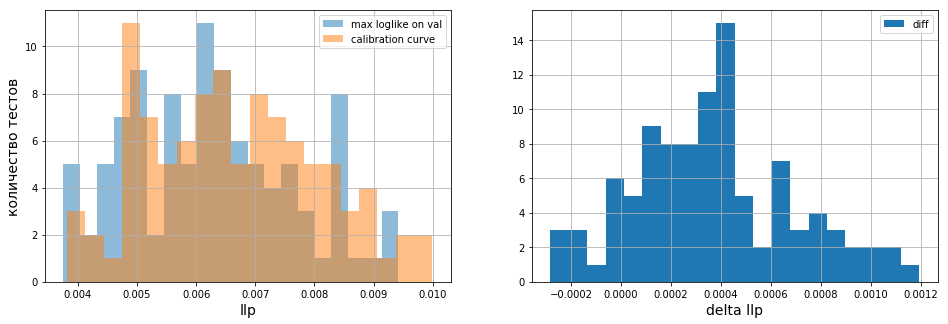

In [57]:
ers = np.array(ers)
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
#plt.title("Распределение для 100 различных тестов с меньшим значением датасетов в каждом. L=70, n=100")
plt.hist(ers[:,0], alpha=0.5, label='max loglike on val', bins=20)
plt.hist(ers[:,1], alpha=0.5, label='calibration curve', bins=20)
plt.ylabel('количество тестов', fontsize=14)
plt.xlabel("llp", fontsize=14)
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.hist(ers[:,1] - ers[:,0], label='diff', bins=20)
plt.xlabel("delta llp", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [23]:
6 * 4 * 10 / 60 * 2 * 30 / 60

4.0

In [40]:
vals = []
data = []
L = 30
n = 50

for i in tqdm(range(200)):
    print (L, n)
    IV += 1
    ans = evaluate_compare([
        stupid_solution,
        mean_value_solution,
        mean_std_value_solution,
        calibration_curve_solution,
    ], DataSet(3000, n, L, random_seed=IV), False, [
        'stupid', 'mean_value', 'mean_std', 'calibration_curve'
    ], True)
    vals.append([a[0] for a in ans])

30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 50
30 5

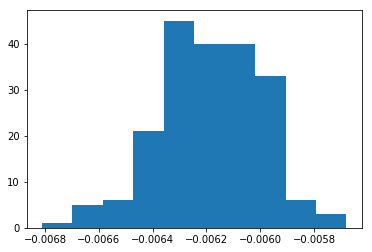

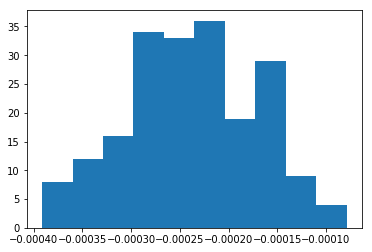

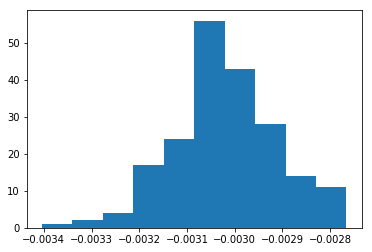

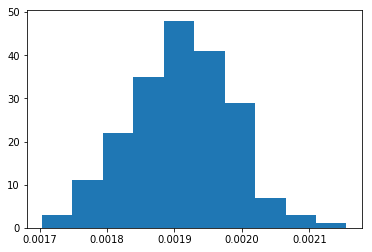

In [42]:
vals = np.array(vals)
for i in range(4):
    plt.hist(vals[:, i] - vals[:, i + 1])
    plt.show()

10 10


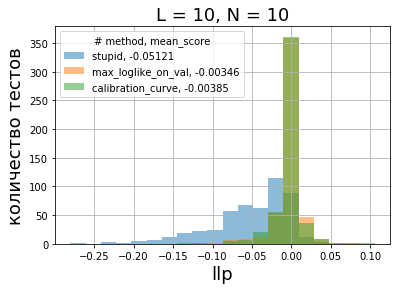

(-0.05121377549205308, 500)
(-0.0034610535222624225, 500)
(-0.0038492093195247605, 500)
10 20


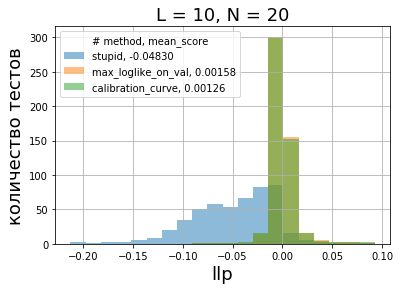

(-0.04830084396480312, 500)
(0.0015841145105874688, 500)
(0.0012615537098042706, 500)
10 40


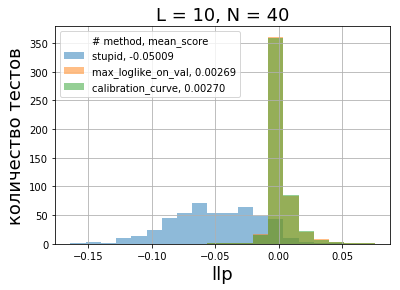

(-0.05009190700787283, 500)
(0.002694415173718385, 500)
(0.002701264392135455, 500)
10 100


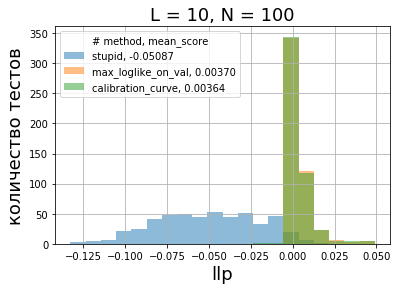

(-0.05086722036183773, 500)
(0.003704554138555186, 500)
(0.0036431094061098834, 500)


30 10


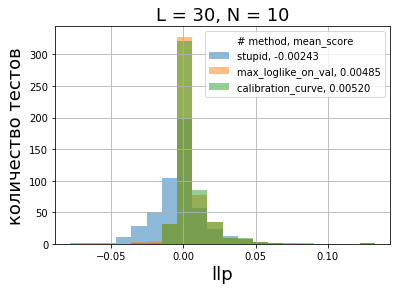

(-0.0024303401261154393, 500)
(0.004850623045370714, 500)
(0.005200843256974746, 500)
30 20


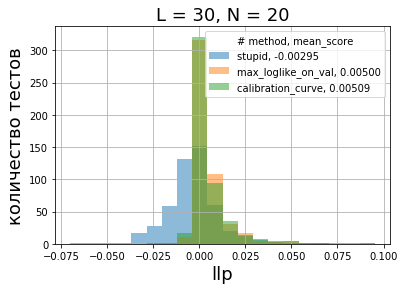

(-0.002950657523641527, 500)
(0.00500390488127433, 500)
(0.0050856943818656745, 500)
30 40


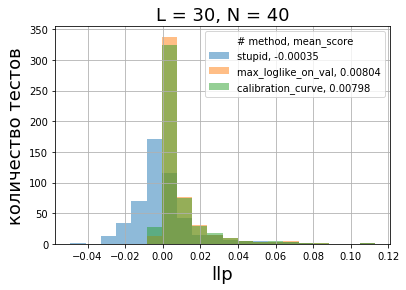

(-0.0003520925812074318, 500)
(0.008042504457232875, 500)
(0.007980808610765262, 500)
30 100


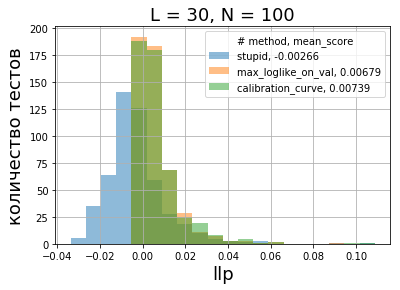

(-0.002656501030305085, 500)
(0.006785943128063622, 500)
(0.007390941939603959, 500)


50 10


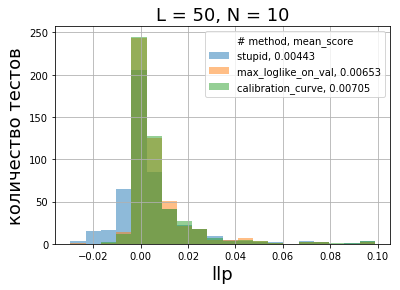

(0.0044259547626663885, 500)
(0.006531704360460194, 500)
(0.007052533413512185, 500)
50 20


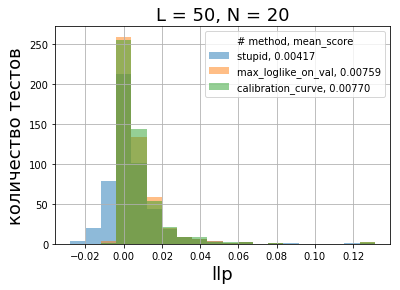

(0.00416834976772115, 500)
(0.0075935719037458025, 500)
(0.007703478998037311, 500)
50 40


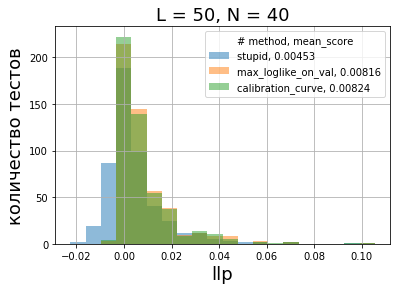

(0.004533000415945097, 500)
(0.008159781827921812, 500)
(0.008242794184482278, 500)
50 100


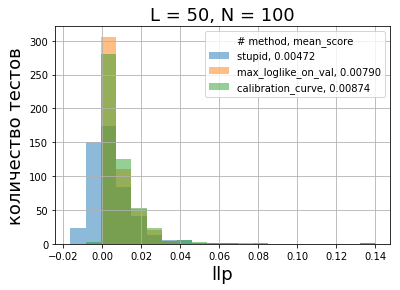

(0.004718569714575064, 500)
(0.0078973418664198, 500)
(0.008736449900785684, 500)


70 10


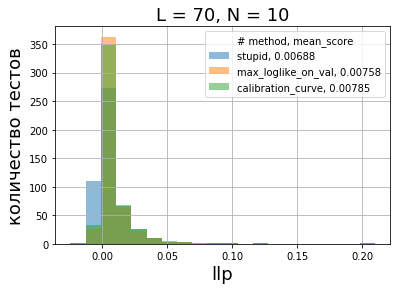

(0.0068792932068874124, 500)
(0.007579136297922927, 500)
(0.007845558659860414, 500)
70 20


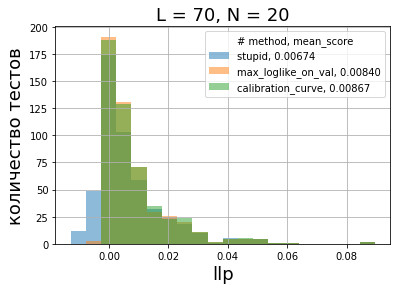

(0.006742293727479525, 500)
(0.008396472288471988, 500)
(0.008668393370350585, 500)
70 40


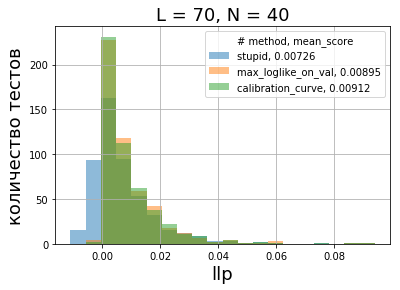

(0.00726247841457222, 500)
(0.0089547473795573, 500)
(0.009123988065259065, 500)
70 100


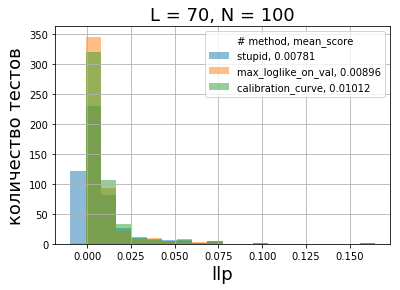

(0.007808048224756498, 500)
(0.008961554105164464, 500)
(0.01012477996693087, 500)


100 10


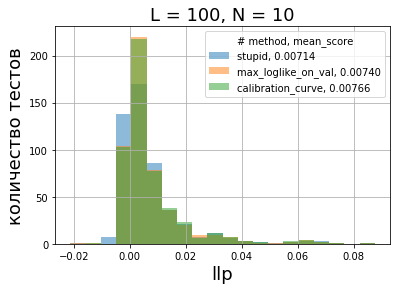

(0.007135551516629488, 500)
(0.007396034929825185, 500)
(0.00766242612674001, 500)
100 20


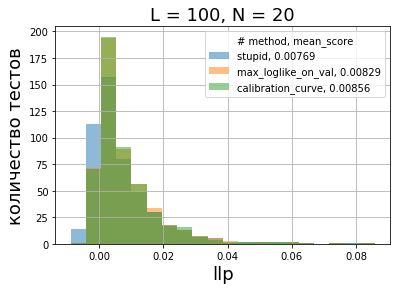

(0.0076907434095177364, 500)
(0.008289407752491446, 500)
(0.008564573745556324, 500)
100 40


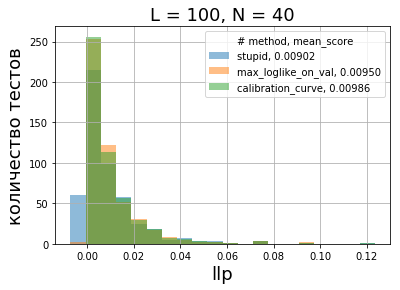

(0.00901782951556544, 500)
(0.00949521139188462, 500)
(0.00986179968522617, 500)
100 100


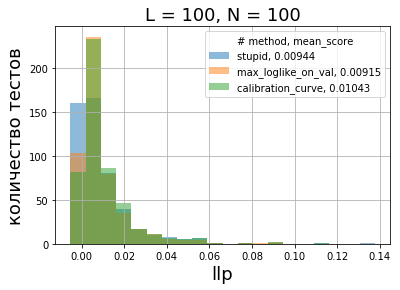

(0.00943990971812048, 500)
(0.009149896737487473, 500)
(0.010430887516699443, 500)


300 10


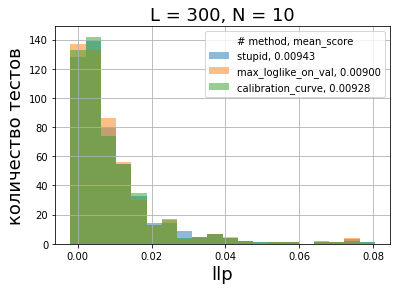

(0.009433827304537236, 500)
(0.00900405610324388, 500)
(0.009279040736584377, 500)
300 20


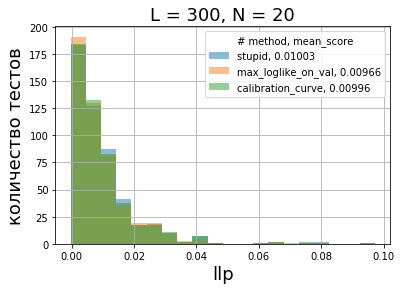

(0.010033178053218766, 500)
(0.00966217193841848, 500)
(0.00996024017294954, 500)
300 40


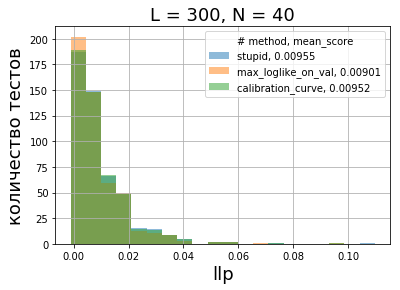

(0.00955466105246261, 500)
(0.009007613962647074, 500)
(0.009515210335455788, 500)
300 100


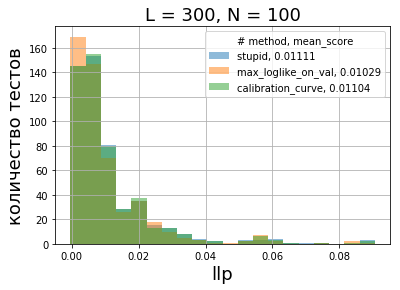

(0.011110671620832136, 500)
(0.010286815606235171, 500)
(0.011042032031618963, 500)


In [58]:
IV = 0
data = []
for L in [10, 30, 50, 70, 100, 300]:
    for n in tqdm([10, 20, 40, 100]):
        print (L, n)
        IV += 1
        plt.figure()
        plt.title("L = %d, N = %d" % (L, n,), fontsize=18)
        ans = evaluate_compare([
            stupid_solution,
            max_loglike_solution,
            calibration_curve_solution,
        ], DataSet(500, n, L, random_seed=IV), True, [
            'stupid', 'max_loglike_on_val', 'calibration_curve'
        ], False)
        data.append((L, n, IV, ans))
        for i in range(len(ans)):
            print (ans[i])

10 10


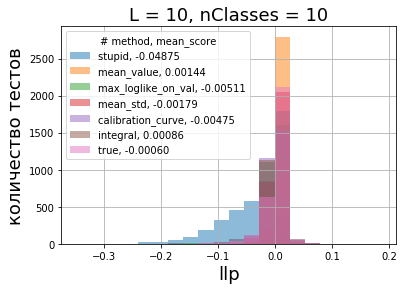

(-0.04875310035471513, 3000)
(0.0014411830296831602, 3000)
(-0.005108947855317022, 3000)
(-0.0017928966472131422, 3000)
(-0.004754465183806472, 3000)
(0.0008640432294570664, 3000)
(-0.0006031550519809709, 3000)
10 20


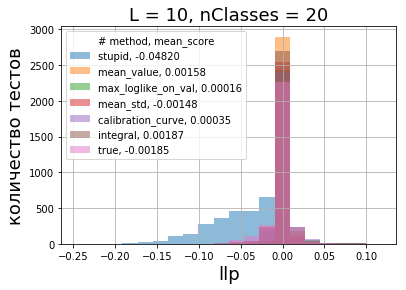

(-0.04820031389866032, 3000)
(0.0015829673200833175, 3000)
(0.00016385604118835788, 3000)
(-0.001478849933974976, 3000)
(0.0003520373858895988, 3000)
(0.001872074460210144, 3000)
(-0.0018532807486407548, 3000)
10 40


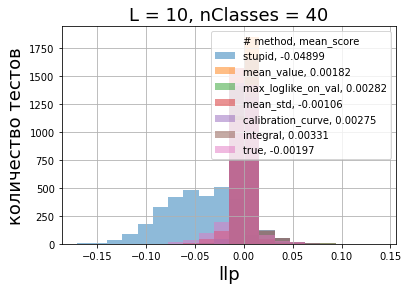

(-0.048987323056434016, 3000)
(0.0018232584981509093, 3000)
(0.0028196558646324003, 3000)
(-0.0010647950685817834, 3000)
(0.002753182182275881, 3000)
(0.0033078775726299654, 3000)
(-0.0019654974285829123, 3000)
10 100


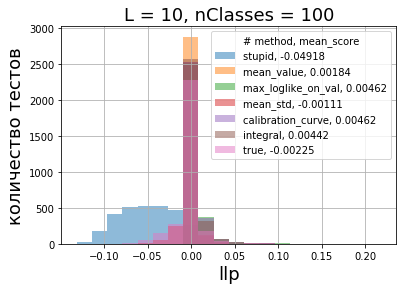

(-0.04917709202512809, 3000)
(0.0018367631063769402, 3000)
(0.0046213404591268666, 3000)
(-0.0011061594200269796, 3000)
(0.004616519327077923, 3000)
(0.004418956140590421, 3000)
(-0.0022484980037966087, 3000)


30 10


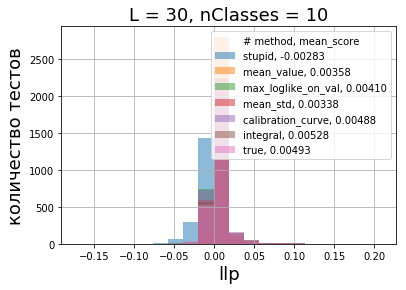

(-0.002826174375391698, 3000)
(0.0035834581133909254, 3000)
(0.004100480664536884, 3000)
(0.0033838927522894598, 3000)
(0.004882946465337717, 3000)
(0.005280162339379029, 3000)
(0.004926116246082073, 3000)
30 20


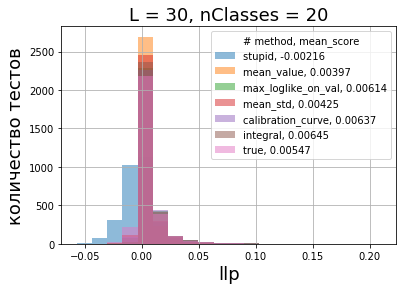

(-0.002163001067213956, 3000)
(0.003968315392806969, 3000)
(0.006136016877617431, 3000)
(0.004253380833794227, 3000)
(0.006370637832392763, 3000)
(0.006446212170027682, 3000)
(0.00547340074849989, 3000)
30 40


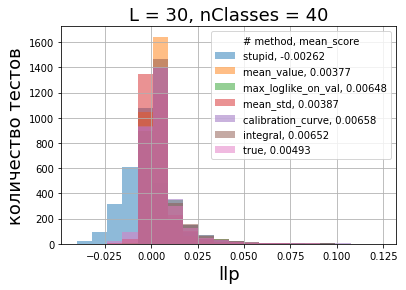

(-0.002617425489932792, 3000)
(0.003774999085505378, 3000)
(0.006476322244389692, 3000)
(0.0038721475062503453, 3000)
(0.006576226285861401, 3000)
(0.006523974503288348, 3000)
(0.0049322152529079595, 3000)
30 100


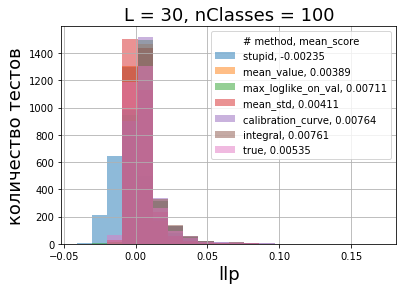

(-0.002351935975688816, 3000)
(0.0038931272648715202, 3000)
(0.00711192011888518, 3000)
(0.004113617105559208, 3000)
(0.007639417495215738, 3000)
(0.0076108221247587595, 3000)
(0.005354779713013111, 3000)


50 10


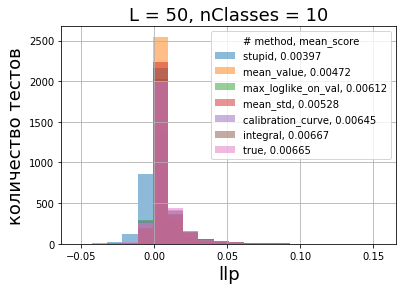

(0.003966366231055204, 3000)
(0.004718074418818291, 3000)
(0.006115266134351091, 3000)
(0.005279181916669147, 3000)
(0.0064542246658100925, 3000)
(0.006670571867072235, 3000)
(0.006650063161273598, 3000)
50 20


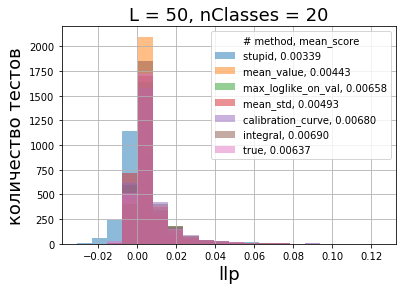

(0.0033924455987235725, 3000)
(0.004429107631262952, 3000)
(0.006575667122794494, 3000)
(0.004931823244613416, 3000)
(0.006800682509580806, 3000)
(0.006902180312445559, 3000)
(0.0063739797751044235, 3000)
50 40


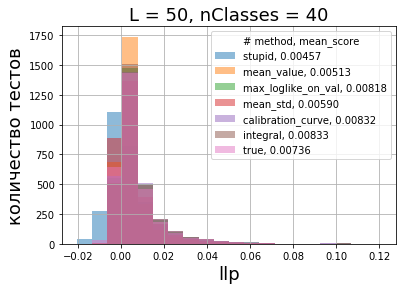

(0.00457155766189264, 3000)
(0.005126599344832744, 3000)
(0.008178035761880564, 3000)
(0.005898319398540245, 3000)
(0.008316106141816885, 3000)
(0.008326213824053753, 3000)
(0.007361342094189965, 3000)
50 100


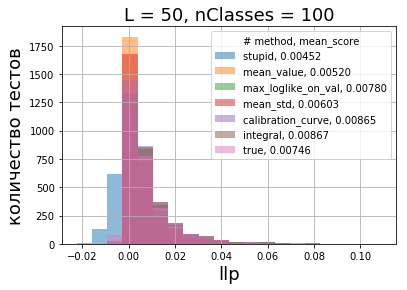

(0.004521113169183541, 3000)
(0.005196573946225998, 3000)
(0.007804976634728825, 3000)
(0.006026275996799459, 3000)
(0.008654458518275386, 3000)
(0.008669293068231275, 3000)
(0.0074625573886706945, 3000)


70 10


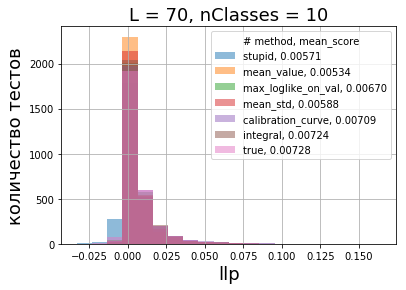

(0.00571462634860091, 3000)
(0.005342683589581213, 3000)
(0.006701089898765995, 3000)
(0.005883542366879849, 3000)
(0.007086826828203577, 3000)
(0.007240694588055942, 3000)
(0.007280340316343734, 3000)
70 20


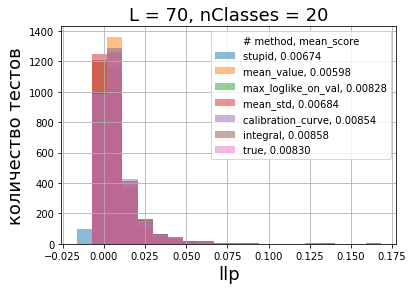

(0.006741653782530323, 3000)
(0.0059782306066588865, 3000)
(0.008281419503380785, 3000)
(0.0068446115497393205, 3000)
(0.008543729109519019, 3000)
(0.008577387565437697, 3000)
(0.008303279737180804, 3000)
70 40


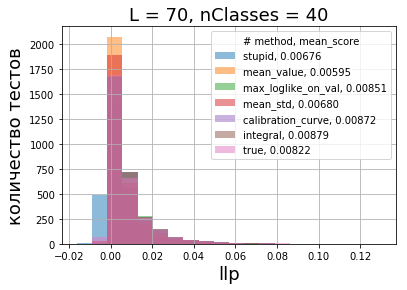

(0.006756251882864994, 3000)
(0.005953173647449982, 3000)
(0.00851222879580344, 3000)
(0.006800687622300449, 3000)
(0.008723614725022338, 3000)
(0.008787528044876309, 3000)
(0.008216858448399988, 3000)
70 100


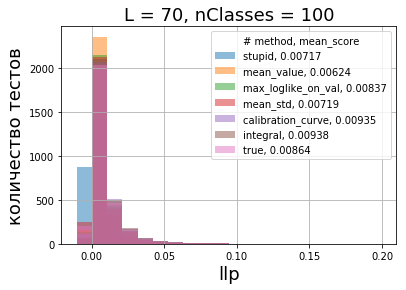

(0.007171524591509713, 3000)
(0.006241562989875708, 3000)
(0.008367226053850712, 3000)
(0.0071903949615115936, 3000)
(0.009346493724013416, 3000)
(0.009381243410999492, 3000)
(0.00863559657468599, 3000)


100 10


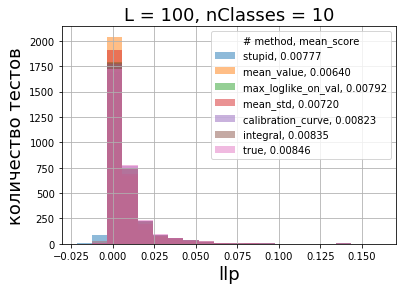

(0.007774302124737533, 3000)
(0.006404840222886355, 3000)
(0.007918431966847397, 3000)
(0.007197330961725311, 3000)
(0.008229611352961297, 3000)
(0.008353742348285119, 3000)
(0.008460773889427928, 3000)
100 20


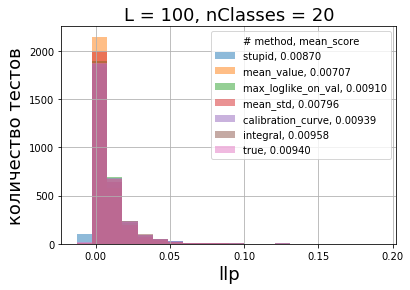

(0.008703001889120644, 3000)
(0.007070267575388097, 3000)
(0.009103441279587308, 3000)
(0.007963137931520163, 3000)
(0.009390875116502374, 3000)
(0.009575331988727948, 3000)
(0.00940450760028935, 3000)
100 40


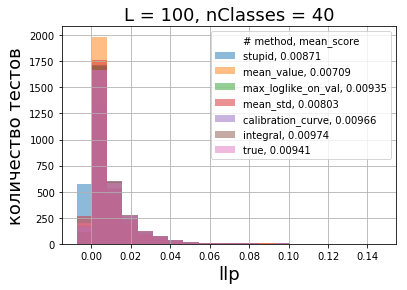

(0.00870994330032973, 3000)
(0.007087128406345902, 3000)
(0.009345002303037536, 3000)
(0.00803174102875553, 3000)
(0.00965989048066129, 3000)
(0.009736612946692931, 3000)
(0.009411316422270359, 3000)
100 100


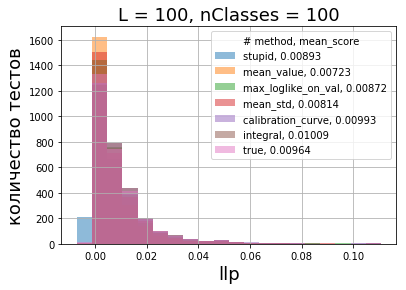

(0.008934250099781329, 3000)
(0.007233846094931621, 3000)
(0.008721880668569314, 3000)
(0.008141408155642524, 3000)
(0.009926760692724423, 3000)
(0.010089484105858445, 3000)
(0.00964118209626984, 3000)


300 10


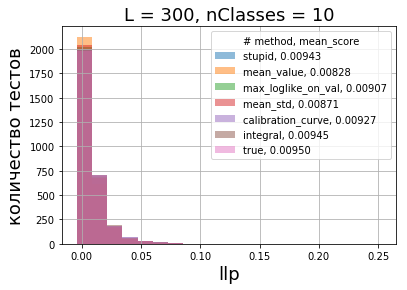

(0.009428903811020581, 3000)
(0.008276850426754637, 3000)
(0.00906999640941558, 3000)
(0.008705059735926947, 3000)
(0.00927026317561564, 3000)
(0.009447462988931642, 3000)
(0.009496037287750482, 3000)
300 20


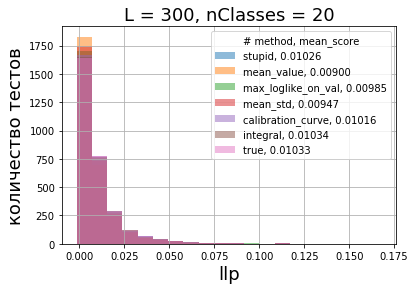

(0.010260278519112497, 3000)
(0.009001378704938293, 3000)
(0.009854873468464987, 3000)
(0.009465449841320712, 3000)
(0.010157276208812885, 3000)
(0.010337536156683827, 3000)
(0.010334540973251701, 3000)
300 40


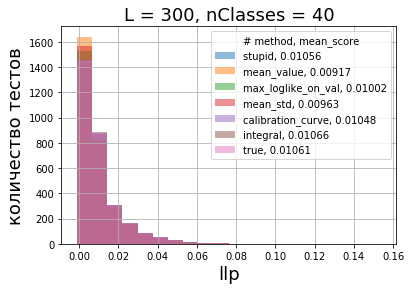

(0.010556217890676626, 3000)
(0.009172837019289002, 3000)
(0.010018206283852762, 3000)
(0.009629600662389196, 3000)
(0.010476125013988377, 3000)
(0.010662903399166148, 3000)
(0.01061282011038807, 3000)
300 100


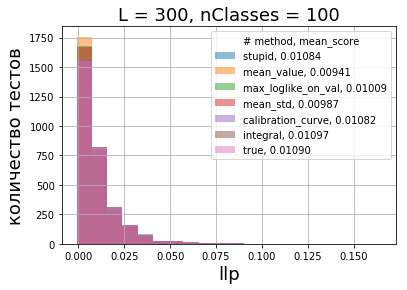

(0.010840514964215802, 3000)
(0.009412755399862097, 3000)
(0.010087970202783772, 3000)
(0.009868662310345448, 3000)
(0.010824762725843906, 3000)
(0.010974344662346378, 3000)
(0.01090086389632936, 3000)


In [25]:
IV = 0
data = []
for L in [10, 30, 50, 70, 100, 300]:
    for n in tqdm([10, 20, 40, 100]):
        print (L, n)
        IV += 1
        plt.figure()
        plt.title("L = %d, nClasses = %d" % (L, n,), fontsize=18)
        ans = evaluate_compare([
            stupid_solution,
            mean_value_solution,
            max_loglike_solution,
            mean_std_value_solution,
            calibration_curve_solution,
            super_puper_solution2,
        ], DataSet(3000, n, L, random_seed=IV), True, [
            'stupid', 'mean_value', 'max_loglike_on_val', 'mean_std', 'calibration_curve', 'integral'
        ], True)
        data.append((L, n, IV, ans))
        for i in range(len(ans)):
            print (ans[i])

In [28]:
data[0][3]

[(10, 10, 1, [...]),
 (10, 20, 2, [...]),
 (10, 40, 3, [...]),
 (10, 100, 4, [...]),
 (30, 10, 5, [...]),
 (30, 20, 6, [...]),
 (30, 40, 7, [...]),
 (30, 100, 8, [...]),
 (50, 10, 9, [...]),
 (50, 20, 10, [...]),
 (50, 40, 11, [...]),
 (50, 100, 12, [...]),
 (70, 10, 13, [...]),
 (70, 20, 14, [...]),
 (70, 40, 15, [...]),
 (70, 100, 16, [...]),
 (100, 10, 17, [...]),
 (100, 20, 18, [...]),
 (100, 40, 19, [...]),
 (100, 100, 20, [...]),
 (300, 10, 21, [...]),
 (300, 20, 22, [...]),
 (300, 40, 23, [...]),
 (300, 100, 24, [...])]

In [ ]:
evaluate_compare([
    stupid_solution,
    mean_value_solution,
    max_loglike_solution,
    max_loglike_solution2,
    calibration_curve_solution,
    mean_std_value_solution,
    super_puper_solution2,
], data_set_big, True, [
    'stup', 'm', 'll', 'll2', 'cc', 'ms', 'cc2', 'sp'
])

In [ ]:
for L in [10, 20, 30, 50, 70, 100, 150, 200, 300, 1000, 3000]:
    print (L)
    ans = evaluate_compare([
            stupid_solution,
            mean_value_solution,
            max_loglike_solution,
            max_loglike_solution2,
            calibration_curve_solution,
            mean_std_value_solution,
            modified_calibration_curve_solution,
            super_puper_solution2,
        ], DataSet(200, 20, L, random_seed=42), True, [
            'stup', 'm', 'll', 'll2', 'cc', 'ms', 'cc2', 'sp'
        ])
    for i in range(len(ans)):
        print (ans[i])